In [1]:
suppressPackageStartupMessages(library(TwoSampleMR))
suppressPackageStartupMessages(library(MRPRESSO))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(grid))
suppressPackageStartupMessages(library(shadowtext))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(lattice))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(tidyverse))

In [7]:
#Save out lead variants from pQTL credible sets to use as MR instruments
st16 <- fread('//UKB-PPP_st16_Nature.tsv') #UKB-PPP Nature paper SuSiE credible sets- supplemental table 16
for (x in unique(st16$`UKBPPP ProteinID`)){
    new_susie_variants <- st16[which(st16$`UKBPPP ProteinID` == x),]$`Variant ID`
    underscores <- gsub(':', '_', x)
    full_sumstat_files <- list.files('//UKB-PPP/', pattern= '.tsv.gz')
    sumstat_file <- full_sumstat_files[grep(underscores, full_sumstat_files)]
    full_sumstat <- fread(paste0('//UKB-PPP/', sumstat_file))
    save <- full_sumstat[which(full_sumstat$ID %in% new_susie_variants),]
    fwrite(save, paste0('//All_Proteins_SuSiE_variants_Nature/', underscores, '_all_SuSiE_variants_Nature_2023.tsv'))
}

In [2]:
t1d_no_ukb <- fread('/T1D_meta_no_UKB.all_chr.hg38.sumstats.txt.gz')
t1d_no_ukb$SNPID <- paste0('chr', t1d_no_ukb$SNPID)
t1d_no_ukb$Phenotype <- 'T1D_no_UKB'
t1d_no_ukb <- as.data.frame(t1d_no_ukb)

t1d_no_ukb_outcome_dat <- format_data(t1d_no_ukb, 
 type = 'outcome',
  header = TRUE,
  phenotype_col = 'Phenotype',
  snp_col = 'SNPID',
  beta_col = 'BETA',
  se_col = 'SE',
  eaf_col = 'AF',
  effect_allele_col = 'ALT',
  other_allele_col = 'REF',
  pval_col = 'PVALUE',
  samplesize_col = 'N',
  log_pval = FALSE
)

t1d_no_ukb <- NULL
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,43426242,2319.3,190689152,10183.9,238361440,12729.9
Vcells,701674273,5353.4,2255971426,17211.7,2343703382,17881.1


## Cis + Trans variants 

In [4]:
setwd('/All_Proteins_SuSiE_variants_Nature/')
files <- list.files('/All_Proteins_SuSiE_variants_Nature/')

results <- data.frame()
wald_res <- data.frame()
res_loo_res <- data.frame()
for (x in files){
       tryCatch({  
    protein <- paste0('/All_Proteins_SuSiE_variants_Nature/', x)
    protein_name <- gsub('_all_SuSiE_variants_Nature_2023.tsv', '', x)
    protein_name2 <- str_split_fixed(protein_name, '_', n=2)[1]

    protein_file <- fread(protein)
    protein_file <- protein_file[which(protein_file$P_VALUE < 1.7e-11),]
    protein_file$Phenotype <- protein_name
    protein_file$SNP <- paste0('chr', protein_file$CHROM,':',protein_file$GENPOS, ':', protein_file$ALLELE0, ':', protein_file$ALLELE1)

    protein_exp_dat <- format_data(protein_file, 
         type = 'exposure',
          header = TRUE,
          phenotype_col = 'Phenotype',
          snp_col = 'SNP',
          beta_col = 'BETA',
          se_col = 'SE',
          eaf_col = 'A1FREQ',
          effect_allele_col = 'ALLELE1',
          other_allele_col = 'ALLELE0',
          pval_col = 'P_VALUE',
          log_pval = FALSE)
    
    dat <- harmonise_data(exposure_dat = protein_exp_dat, outcome_dat = t1d_no_ukb_outcome_dat, action = 2) 
    res <- mr(dat, method_list=c('mr_egger_regression','mr_ivw'))
    results <- rbind(results, res)
    wald_res0 <- data.frame()
    for (x in 1:nrow(dat)){
        wald <- mr(dat[x,], method_list=c('mr_wald_ratio'))
        wald$exposure <- paste0(wald$exposure, '_', dat[x,1])
        wald_res0 <- rbind(wald_res0, wald)
    }
   wald_res <- rbind(wald_res, wald_res0)
   results_w_wald <- rbind(results, wald_res)
           
           }, error=function(e){})
}

## Only include variants in cis in instrument

In [59]:
setwd('/All_Proteins_SuSiE_variants_Nature/')
susie <- fread('/UKB-PPP_st16_Nature.tsv')
files <- list.files('/All_Proteins_SuSiE_variants_Nature/')

results <- data.frame()
for (x in files){
       tryCatch({  
    protein <- paste0('/All_Proteins_SuSiE_variants_Nature/', x)
    protein_name <- gsub('_all_SuSiE_variants_Nature_2023.tsv', '', x)

    protein_file <- fread(protein)
    protein_file <- protein_file[which(protein_file$P_VALUE < 1.7e-11),]
    protein_file$Phenotype <- protein_name
    protein_file$SNP <- paste0('chr', protein_file$CHROM,':',protein_file$GENPOS, ':', protein_file$ALLELE0, ':', protein_file$ALLELE1)

    protein_name_susie <- gsub('_', ':', protein_name)
    protein_susie <- susie[which(susie$`UKBPPP ProteinID` == protein_name_susie),]

    protein_file <- merge(protein_file, protein_susie, by.x='ID', by.y='Variant ID')
    protein_file <- protein_file[which(protein_file$`Cis/trans` == 'cis'),] #####################

    protein_exp_dat <- format_data(protein_file, 
         type = 'exposure',
          header = TRUE,
          phenotype_col = 'Phenotype',
          snp_col = 'SNP',
          beta_col = 'BETA',
          se_col = 'SE',
          eaf_col = 'A1FREQ',
          effect_allele_col = 'ALLELE1',
          other_allele_col = 'ALLELE0',
          pval_col = 'P_VALUE',
          log_pval = FALSE)
    
    dat <- harmonise_data(exposure_dat = protein_exp_dat, outcome_dat = t1d_no_ukb_outcome_dat, action = 2) 
    
    res <- mr(dat, method_list=c('mr_egger_regression','mr_ivw'))
    results <- rbind(results, res)
    wald_res0 <- data.frame()
    for (x in 1:nrow(dat)){
        wald <- mr(dat[x,], method_list=c('mr_wald_ratio'))
        wald$exposure <- paste0(wald$exposure, '_', dat[x,1])
        wald_res0 <- rbind(wald_res0, wald)
    }
   wald_res <- rbind(wald_res, wald_res0)
   results_w_wald <- rbind(results, wald_res)
           
           }, error=function(e){})
}

Harmonising CTRB1_P17538_OID21150_v1 (p7kV60) and T1D_no_UKB (OyoNIH)

Analysing 'p7kV60' on 'OyoNIH'

Analysing 'p7kV60' on 'OyoNIH'

Analysing 'p7kV60' on 'OyoNIH'

Analysing 'p7kV60' on 'OyoNIH'

Analysing 'p7kV60' on 'OyoNIH'

Analysing 'p7kV60' on 'OyoNIH'



## Using cis variants from pQTLs in eQTLs 

In [3]:
gtex_tissues <- list.files('/GTEx/GTEx_v8/GTEx_Analysis_v8_eQTL_all_associations/', pattern='.txt.gz')
gtex_tissues <- gsub('.allpairs.txt.gz', '', gtex_tissues)
susie <- fread('UKB-PPP_st16_Nature.tsv')
files <- list.files('/All_Proteins_SuSiE_variants_Nature/')

res_fin <- data.frame()
wald_res <- data.frame()
results_w_wald <- data.frame()
for (x in unique(gtex_tissues)){ 
    tissue_qtl <- vroom::vroom(paste0('/GTEx/GTEx_v8/GTEx_Analysis_v8_EUR_eQTL_all_associations/',x,'_EUR_all_chr.tsv.gz'), show_col_types = FALSE)
    
    for (y in files){
        protein <- paste0('/All_Proteins_SuSiE_variants_Nature/', y)
        protein_name <- gsub('_all_SuSiE_variants_Nature_2023.tsv', '', y)
        protein_name <- str_split_fixed(protein_name, '_', n=2)[1]

        protein_file <- fread(protein)
        protein_file <- protein_file[which(protein_file$P_VALUE < 1.7e-11),]
        protein_file$Phenotype <- protein_name
        protein_file$SNP <- paste0('chr', protein_file$CHROM,'_',protein_file$GENPOS, '_', protein_file$ALLELE0, '_', protein_file$ALLELE1, '_b38')

        protein_susie <- susie[grep(paste0('\\b',protein_name,':'),susie$`UKBPPP ProteinID`),]

        protein_file <- merge(protein_file, protein_susie, by.x='ID', by.y='Variant ID')
        protein_file <- protein_file[which(protein_file$`Cis/trans` == 'cis'),] #####################
               
        gtex_id <- test[which(test$Gene == protein_name),]$GTEx_ID
        gene <- tissue_qtl[which(tissue_qtl$phenotype_id == gtex_id),]
        gene <- gene[which(gene$variant_id %in% protein_file$SNP),]

        if (nrow(gene) > 0 ){
            gene$ALLELE0 <- as.data.frame(str_split_fixed(gene$variant_id, '_', n=5))$V3
            gene$ALLELE1 <- as.data.frame(str_split_fixed(gene$variant_id, '_', n=5))$V4
            gene$variant_id <- gsub('_b38','', gene$variant_id)
            gene$variant_id <- gsub('_',':', gene$variant_id)

            eqtl_exp_dat <- format_data(gene, 
                     type = 'exposure',
                      header = TRUE,
                      phenotype_col = 'gene_id',
                      snp_col = 'variant_id',
                      beta_col = 'slope',
                      se_col = 'slope_se',
                      eaf_col = 'maf',
                      effect_allele_col = 'ALLELE1',
                      other_allele_col = 'ALLELE0',
                      pval_col = 'pval_nominal',
                      log_pval = FALSE)

            if (nrow(t1d_no_ukb_outcome_dat[which(t1d_no_ukb_outcome_dat$SNP %in% eqtl_exp_dat$SNP),])> 0) {
                dat <- harmonise_data(exposure_dat = eqtl_exp_dat, outcome_dat = t1d_no_ukb_outcome_dat, action = 2) 
                res <- mr(dat, method_list=c('mr_ivw','mr_wald_ratio'))
                if (nrow(res) > 0) {
                    res$tissue <- x
                    res$gene <- y 
                    res_fin <- rbind(res_fin, res)
                wald_res0 <- data.frame()
                for (z in 1:nrow(dat)){
                    wald <- mr(dat[z,], method_list=c('mr_wald_ratio'))
                    if (nrow(wald) > 0){
                    wald$tissue <- x
                    wald$gene <- protein_name
                    wald$exposure <- paste0(wald$exposure, '_', dat[z,1])}
                    wald_res0 <- rbind(wald_res0, wald)
                }
        wald_res <- rbind(wald_res, wald_res0)
        results_w_wald <- rbind(res_fin, wald_res)
                    fwrite(results_w_wald, '/eqtl_cis_variants_from_pQTLs_t1d_mr.tsv', sep='\t', quote=F, col.names=T, row.names=F)
                }  
            }
        }    
    }
}

## Making MR Instruments by LDSC cell type

In [5]:
susie_cre <- fread('SuSiE_variants_cRE_overlap.tsv')
setwd('/All_Proteins_SuSiE_variants_Nature/')
files <- list.files('/All_Proteins_SuSiE_variants_Nature/')

results <- data.frame()
wald_res <- data.frame()
for (i in unique(susie_cre$protein)){
    susie_cre_protein <- susie_cre[which(susie_cre$protein == i),]
    files2 <- files[grep(paste0('\\b',i,'_'), files)]
    protein <- paste0('All_Proteins_SuSiE_variants_Nature/', files2)
    protein_name <- gsub('_all_SuSiE_variants_Nature_2023.tsv', '', files2)
    protein_name2 <- str_split_fixed(protein_name, '_', n=2)[1]

    protein_file <- fread(protein)
    protein_file <- protein_file[which(protein_file$P_VALUE < 1.7e-11),]
    protein_file$Phenotype <- protein_name
    protein_file$SNP <- paste0('chr', protein_file$CHROM,':',protein_file$GENPOS, ':', protein_file$ALLELE0, ':', protein_file$ALLELE1)

    protein_exp_dat <- format_data(protein_file, 
         type = 'exposure',
          header = TRUE,
          phenotype_col = 'Phenotype',
          snp_col = 'SNP',
          beta_col = 'BETA',
          se_col = 'SE',
          eaf_col = 'A1FREQ',
          effect_allele_col = 'ALLELE1',
          other_allele_col = 'ALLELE0',
          pval_col = 'P_VALUE',
          log_pval = FALSE)
    
    dat <- harmonise_data(exposure_dat = protein_exp_dat, outcome_dat = t1d_no_ukb_outcome_dat, action = 2) 
    dat$SNP2 <- paste0(as.data.frame(str_split_fixed(dat$SNP, ':', n=4))$V1, ':',as.data.frame(str_split_fixed(dat$SNP, ':', n=4))$V2)
        for (y in unique(susie_cre_protein$cell_type)){
            susie_cre_protein_celltype <- susie_cre_protein[which(susie_cre_protein$cell_type == y),]
            dat2 <- dat[which(dat$SNP2 %in% susie_cre_protein_celltype$protein_SuSiE_variant),]
            if (nrow(dat2) > 0){
                wald_res0 <- data.frame()
                for (x in 1:nrow(dat2)){
                    wald <- mr(dat2[x,], method_list=c('mr_wald_ratio'))
                    if (nrow(wald) > 0){
                        wald$exposure <- paste0(wald$exposure, '_', dat2[x,1])
                        wald$celltype <- y
                        wald_res0 <- rbind(wald_res0, wald)
                        wald_res <- rbind(wald_res, wald_res0)
                    }
                }
                if (nrow(dat2) > 1){
                    res <- mr(dat2, method_list=c('mr_ivw'))
                    if (nrow(res) >0){
                        res$celltype <- y
                        results <- rbind(results, res)
                    }
                }
            }
        }
    
    results_w_wald <- rbind(results, wald_res)
}

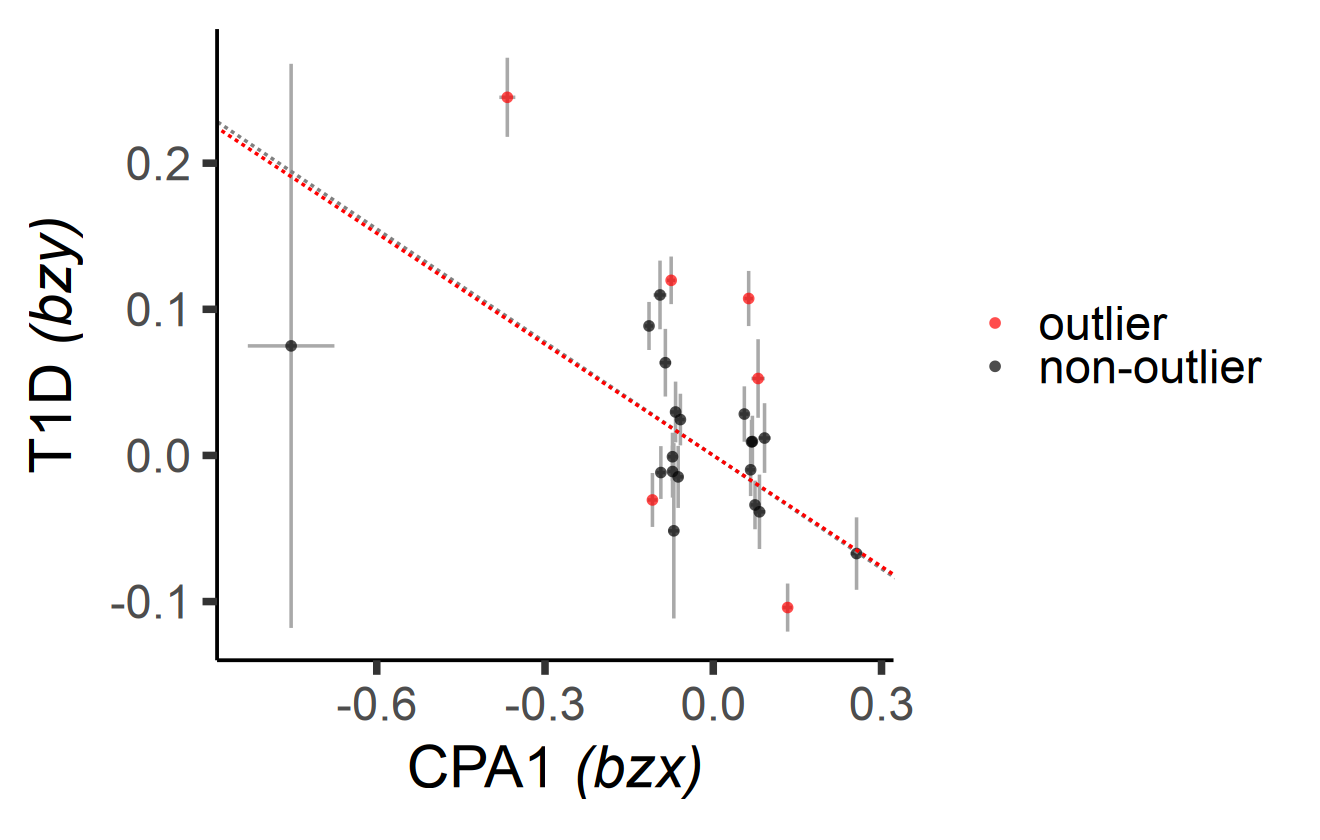

In [290]:
options(repr.plot.width=11, repr.plot.height=7)
ggplot(data = dat, aes(x = beta.exposure, y = beta.outcome, color=outlier)) + theme_classic(base_size=35) +
scale_color_manual(values=c('red', 'black'))+
labs(x=expression(paste('CPA1',italic(' (bzx)')))) + labs(y=expression(paste('T1D ',italic('(bzy)')))) + 
geom_errorbar(aes(ymin = beta.outcome - se.outcome, ymax = beta.outcome + se.outcome), colour = 'darkgrey', width = 0, size=0.75) + 
geom_errorbarh(aes(xmin = beta.exposure - se.exposure, xmax = beta.exposure + se.exposure), colour = 'darkgrey', height = 0, size=0.75) + 
geom_point(size=3, alpha=0.7, pch=19, stroke=NA) + 
geom_abline(data = res, aes(intercept = 0, slope = b[2]), show.legend = FALSE, color = '#808080', linetype='dashed',size=0.75) +
geom_abline(data = res, aes(intercept = 0, slope =-0.2535150), show.legend = FALSE, color = 'red', linetype='dashed',size=0.75) +
theme(axis.line=element_line(size=0.8)) + theme(legend.title=element_blank())

# Plotting All Results

In [3]:
ivw <- fread('UKB-PPP_pQTL_T1D_no_UKB_TSMR_1p7e-11_all_SuSiE_variants.tsv')
ivw <- ivw[which(ivw$method == 'Inverse variance weighted'),]
ivw <- ivw[which(ivw$nsnp >=3),]
ivw$exposure  <- as.data.frame(str_split_fixed(ivw$exposure, '_', n=2))$V1
ivw$qval <- p.adjust(ivw$pval, method='BH')

In [4]:
ivw_plot <- ivw
ivw_plot[which(ivw_plot$b > 2.5),]$b <- 2.5
ivw_plot[which(ivw_plot$b < -2.5),]$b <- -2.5

In [51]:
ivw[which(ivw$b > 0 & ivw$qval < 0.1),]

id.exposure,id.outcome,outcome,exposure,method,nsnp,b,se,pval,qval
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
U38Qx7,RamVK4,T1D_no_UKB,APBB1IP,Inverse variance weighted,3,0.24537480,0.07479206,1.035278e-03,9.544345e-02
D9C2uy,RamVK4,T1D_no_UKB,CASP8,Inverse variance weighted,5,0.24542393,0.07172675,6.224207e-04,7.188959e-02
iyKmxr,RamVK4,T1D_no_UKB,CCN3,Inverse variance weighted,7,0.14137171,0.03581069,7.888851e-05,1.665989e-02
xyqM2I,RamVK4,T1D_no_UKB,HLA-DRA,Inverse variance weighted,8,1.64020601,0.43263865,1.499402e-04,2.518995e-02
OwfHnl,RamVK4,T1D_no_UKB,IDUA,Inverse variance weighted,27,0.07510936,0.02172459,5.455290e-04,6.720917e-02
f2sqU1,RamVK4,T1D_no_UKB,KLK1,Inverse variance weighted,27,0.12284446,0.02329812,1.344168e-07,6.210058e-05
twu3yY,RamVK4,T1D_no_UKB,LGMN,Inverse variance weighted,28,0.10554737,0.03222689,1.056120e-03,9.544345e-02
ckZk64,RamVK4,T1D_no_UKB,OSMR,Inverse variance weighted,19,0.09958270,0.02683695,2.067225e-04,3.005437e-02
CWoQPM,RamVK4,T1D_no_UKB,PCDH12,Inverse variance weighted,11,0.11621405,0.02948832,8.113582e-05,1.665989e-02


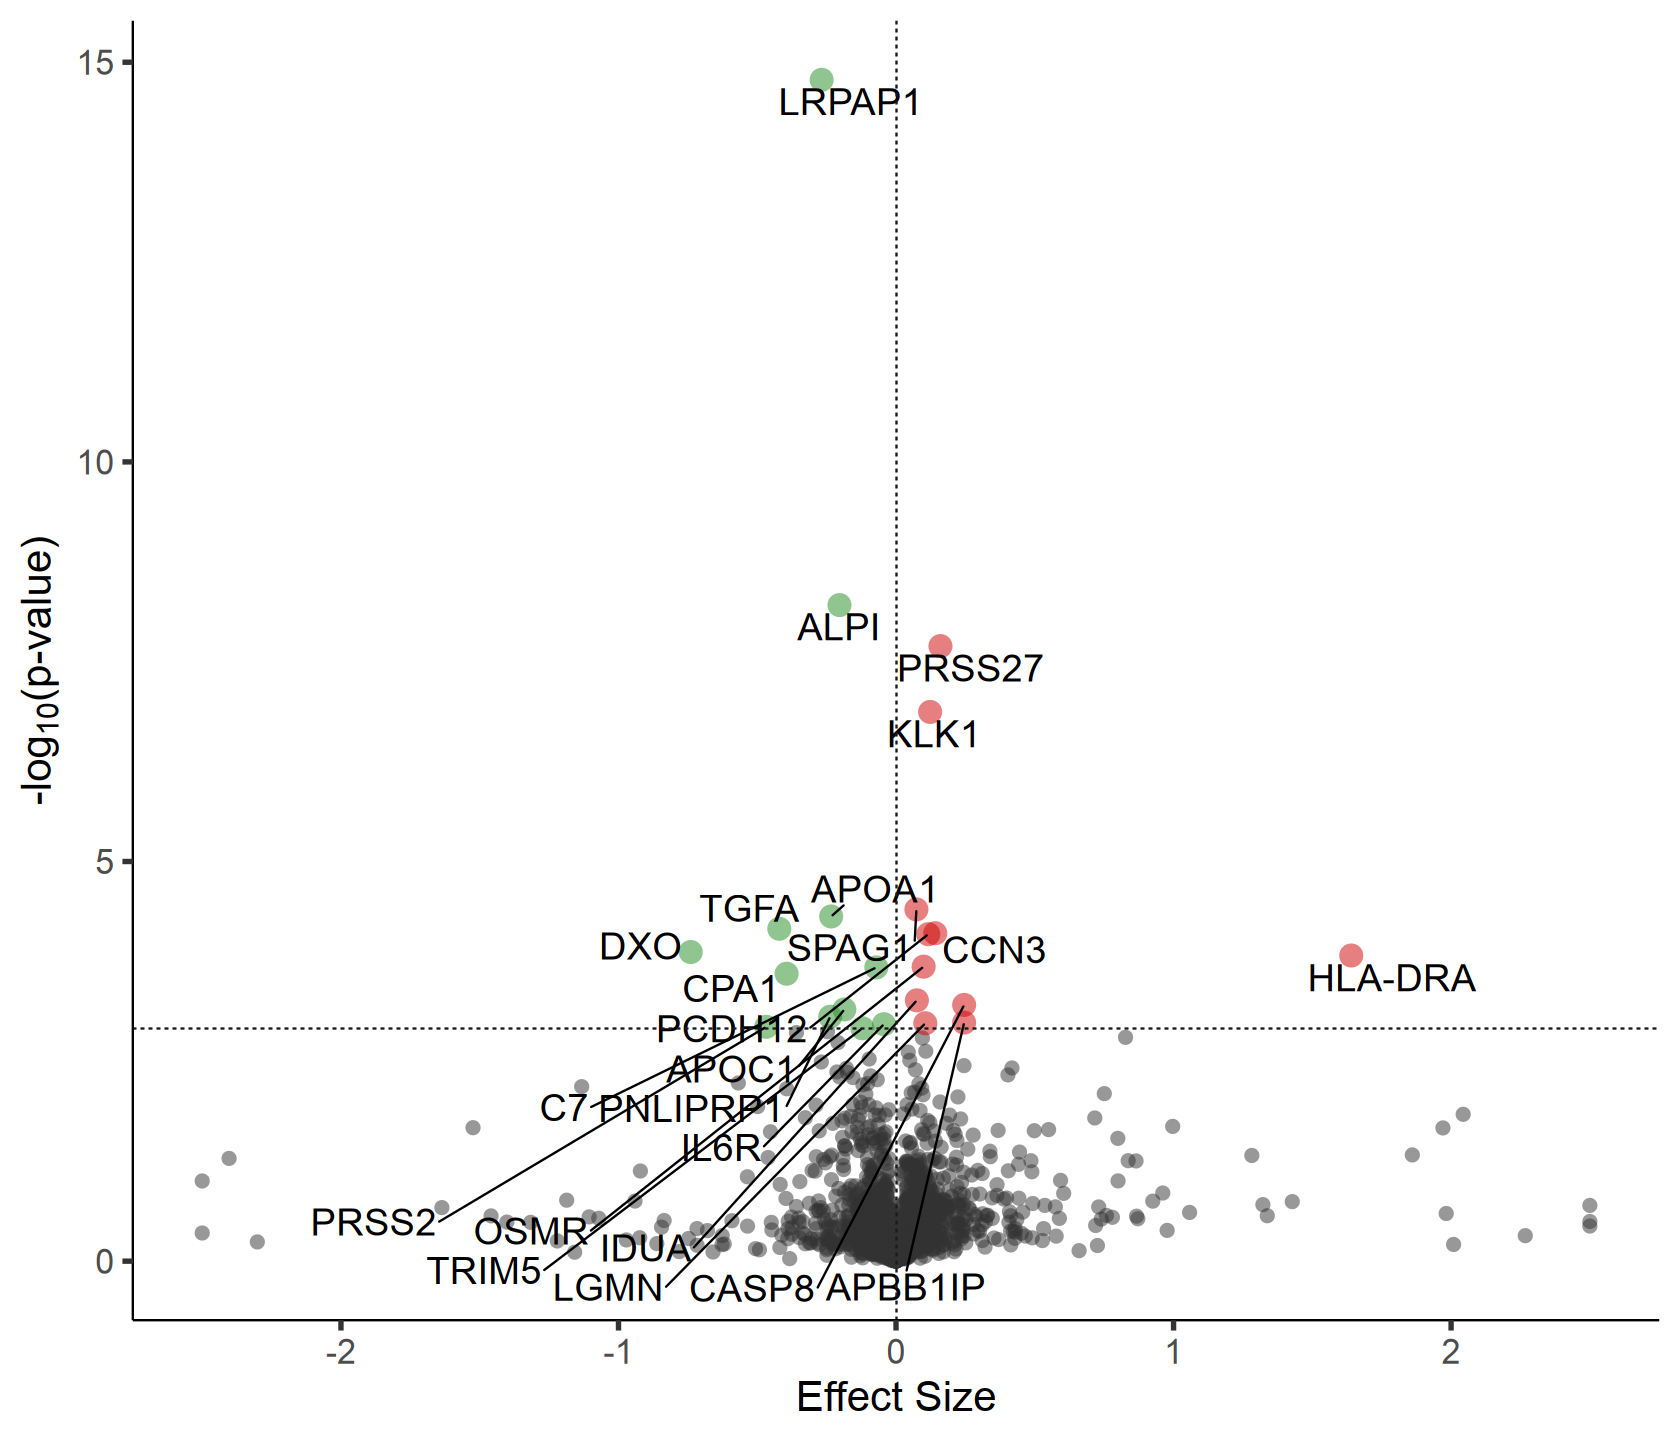

In [49]:
options(repr.plot.width=14, repr.plot.height=12)
ggplot(ivw_plot, aes(b, -log10(pval), label=exposure)) + 
theme_classic(base_size=25) + theme(legend.position = 'none',axis.line = element_line(colour = 'black', linewidth = 0.5)) + 
geom_point(data =ivw_plot %>% filter(qval >= 0.1), color = 'grey20', size=4, alpha=0.5, shape=16, stroke=NA) + 
geom_point(data =ivw_plot %>% filter(qval <= 0.1 & b > 0), color = 'red3', size=6.5, alpha=0.5, shape=16, stroke=NA) + 
geom_point(data =ivw_plot %>% filter(qval <= 0.1 & b < 0), color = 'forestgreen', size=6.5, alpha=0.5, shape=16, stroke=NA) + 
xlab('Effect Size') + ylab(expression(paste('-log'[10],'(p-value)'))) +
geom_text_repel(aes(label=ifelse(qval<=0.1,as.character(exposure),'')),hjust=0,vjust=0, size=8, max.overlaps = 100) +
geom_hline(yintercept=min(-log10(ivw[which(ivw_plot$qval < 0.1),]$pval)), linetype='dashed', col = 'grey10') +
geom_vline(xintercept=0, linetype='dashed', col = 'grey10')

In [35]:
enrichr_neg_res <- fread('/Enrichr/KEGG_2021_Human_table_neg_2922_UKB-PPP_background.txt')
enrichr_pos_res <- fread('/Enrichr/KEGG_2021_Human_table_pos_2922_UKB-PPP_background.txt')
colnames(enrichr_neg_res) <- c('Term', 'Overlap', 'P.value', 'Adjusted.P.value', 'Old.P.value', 'Old.Adjusted.P.value','Odds.Ratio', 'Combined.Score', 'Genes')
colnames(enrichr_pos_res) <- c('Term', 'Overlap', 'P.value', 'Adjusted.P.value', 'Old.P.value', 'Old.Adjusted.P.value','Odds.Ratio', 'Combined.Score', 'Genes')

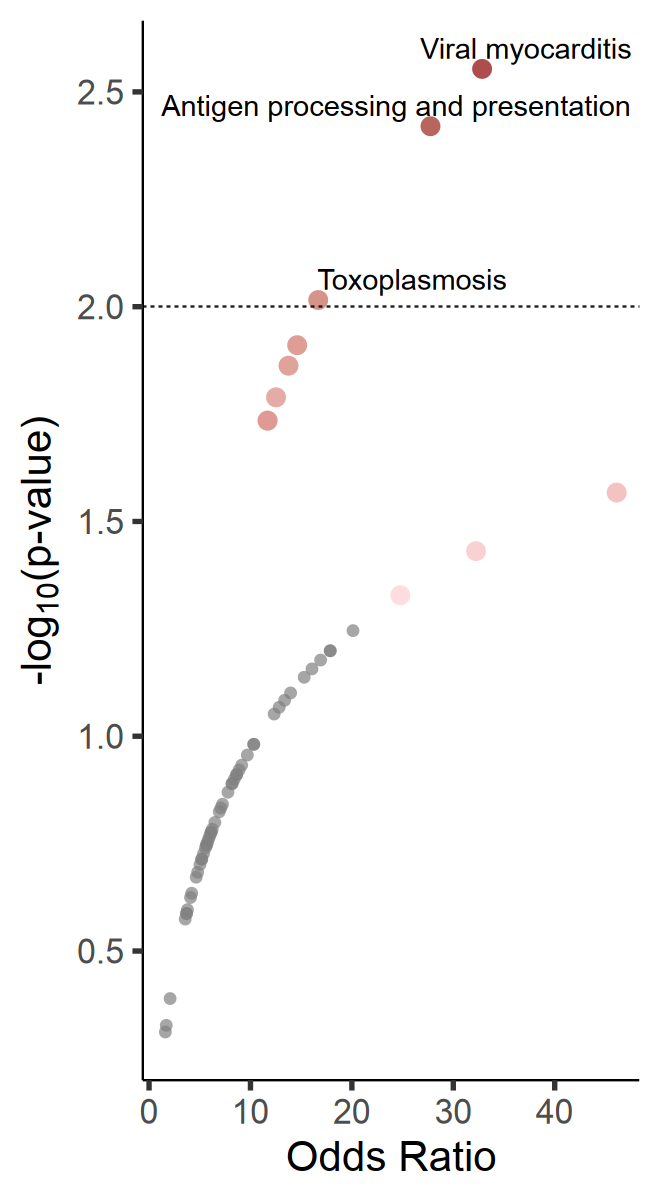

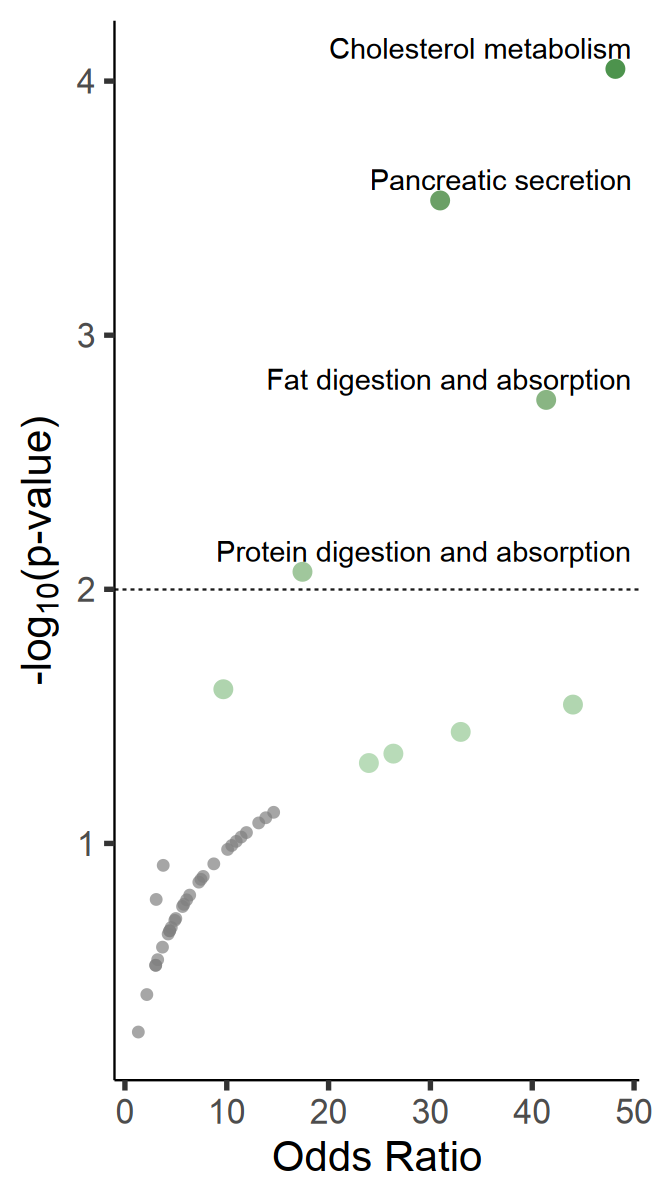

In [40]:
options(repr.plot.width=5.5, repr.plot.height=10)  

ggplot(enrichr_pos_res, aes(Odds.Ratio, -log10(P.value))) + geom_point(data =enrichr_pos_res %>% filter(P.value <= 0.05),aes(color=-log10(P.value)),size=5,shape=16, alpha=0.7) + 
scale_colour_gradient(low = '#FFCDD2',high = 'red4') + 
theme_classic(base_size=25) + theme(legend.position = 'none',axis.line = element_line(colour = 'black', size = 0.5)) + 
geom_point(data =enrichr_pos_res %>% filter(P.value >= 0.05), color = '#808080', size=3, alpha=0.7, shape=16) + 
xlab('Odds Ratio') + ylab(expression(paste('-log'[10],'(p-value)'))) +
geom_text_repel(aes(label=ifelse(P.value<=0.01,as.character(Term),'')),hjust=0,vjust=-0.5, size=6) +
geom_hline(yintercept=2, linetype='dashed', col = 'grey10')


ggplot(enrichr_neg_res, aes(Odds.Ratio, -log10(P.value))) + geom_point(data =enrichr_neg_res %>% filter(P.value <= 0.05),aes(color=-log10(P.value)),size=5,shape=16, alpha=0.7) + 
scale_colour_gradient(low = 'darkseagreen3',high = 'darkgreen') + 
theme_classic(base_size=25) + theme(legend.position = 'none',axis.line = element_line(colour = 'black', size = 0.5)) + 
geom_point(data =enrichr_neg_res %>% filter(P.value >= 0.05), color = '#808080', size=3, alpha=0.7, shape=16) + 
xlab('Odds Ratio') + ylab(expression(paste('-log'[10],'(p-value)'))) +
geom_text_repel(aes(label=ifelse(P.value<=0.01,as.character(Term),'')),hjust=0,vjust=-0.5, size=6) +
geom_hline(yintercept=2, linetype='dashed', col = 'grey10')

## Run MRPRESSO on All Proteins

In [6]:
setwd('/All_Proteins_SuSiE_variants_Nature/')
files <- list.files('All_Proteins_SuSiE_variants_Nature/')


pleiotropy_res <- data.frame()
presso_res <- data.frame()
presso_mr_res <- data.frame()
outliers_res <- data.frame()
for (x in files){
       tryCatch({  
    protein <- paste0('/All_Proteins_SuSiE_variants_Nature/', x)
    protein_name <- gsub('_all_SuSiE_variants_Nature_2023.tsv', '', x)

    protein_file <- fread(protein)
    protein_file <- protein_file[which(protein_file$P_VALUE < 1.7e-11),]
    protein_file$Phenotype <- protein_name
    protein_file$SNP <- paste0('chr', protein_file$CHROM,':',protein_file$GENPOS, ':', protein_file$ALLELE0, ':', protein_file$ALLELE1)
    protein_file <- as.data.frame(protein_file)
           
    protein_exp_dat <- format_data(protein_file, 
         type = 'exposure',
          header = TRUE,
          phenotype_col = 'Phenotype',
          snp_col = 'SNP',
          beta_col = 'BETA',
          se_col = 'SE',
          eaf_col = 'A1FREQ',
          effect_allele_col = 'ALLELE1',
          other_allele_col = 'ALLELE0',
          pval_col = 'P_VALUE',
          log_pval = FALSE)
    
    dat <- harmonise_data(exposure_dat = protein_exp_dat, outcome_dat = t1d_no_ukb_outcome_dat, action = 2) 
    presso <- mr_presso(data = dat, BetaOutcome = 'beta.outcome', BetaExposure = 'beta.exposure', SdOutcome = 'se.outcome', SdExposure = 'se.exposure', OUTLIERtest = TRUE, DISTORTIONtest = TRUE, NbDistribution = 1000,  SignifThreshold = 0.05, seed = 1)
#     #Count MR-PRESSO outliers
#     n_outliers <- as.numeric(unlist(presso$`MR-PRESSO results`[[3]][1]))
#     n_outliers <- length(n_outliers[which(n_outliers >0)])
#     n_snps_total <- nrow(presso$`MR-PRESSO results`[[2]])
#     n_outliers <- as.data.frame(n_outliers)
#     n_outliers$total_snps <- n_snps_total
#     n_outliers$exposure <- protein_name
#     outliers_res <- rbind(outliers_res, n_outliers)
    #MR-PRESSO MR results with outlier correction
    presso_mr <- presso$`Main MR results`
    presso_mr$protein <- protein_name
    presso_mr_res <- rbind(presso_mr_res, presso_mr)
#     #MR-PRESSO pleiotropy results
#     presso2 <- as.data.frame(presso$`MR-PRESSO results`[1])
#     presso2$protein <- protein_name
#     presso2 <- presso2[,c(3,1,2)]
#     colnames(presso2) <- c('Protein','RSSobs', 'Pvalue')
#     presso_res <- rbind(presso_res, presso2)
#     #Egger intercept pleiotropy test
#     pleiotropy <- mr_pleiotropy_test(dat)
#     pleiotropy_res <- rbind(pleiotropy_res, pleiotropy)

           }, error=function(e){})
}

In [21]:
presso_mr$gaussian_pval <- 2 * pnorm(abs(presso_mr$`T-stat`), lower.tail = FALSE)


## Plotting MR Instrument by CATlas cRE

In [2]:
full <- fread('UKB-PPP_pQTL_T1D_no_UKB_TSMR_1p7e-11_all_SuSiE_variants.tsv')
full_ivw <- full[which(full$method == 'Inverse variance weighted'),]
full_ivw <- full_ivw[,c(3:9)]
full_ivw$celltype <- 'all'
full_ivw <- full_ivw[,c(1,2,8,3,4,5,6,7)]
full_ivw$exposure <- as.data.frame(str_split_fixed(full_ivw$exposure, '_', n=2))$V1

In [246]:
celltype <- fread('UKB-PPP_pQTL_T1D_no_UKB_TSMR_1p7e-11_all_SuSiE_variants_by_celltype_cRE.tsv')
celltype <- as.data.frame(celltype)
celltype <- celltype[order(celltype$exposure,celltype$method),]

celltype$variant <- NA
celltype$variant <- as.data.frame(str_split_fixed(celltype$exposure, '_', n=2))$V2
celltype$exposure <-  as.data.frame(str_split_fixed(celltype$exposure, '_', n=2))$V1

celltype <- celltype[!duplicated(celltype[,c(2:3)]),]

celltype <- celltype[order(-celltype$b),]
celltype$celltype <- gsub(' ', '_', celltype$celltype)
celltype2 <- celltype[,c(1:8)]

In [4]:
cpa1_ldsc_res <- fread('/LDSC/Results_no_fetal/CPA1_P15085_OID20280_v1_Cardiometabolic_ldscore_results_no_fetal.tsv')
cpa1_ldsc_res$padj <- p.adjust(cpa1_ldsc_res$Enrichment_p, method='BH')
cpa1_sig_celltypes <- cpa1_ldsc_res[which(cpa1_ldsc_res$padj <=0.1),]$cell_type

In [5]:
prss2_ldsc_res <- fread('/LDSC/Results_no_fetal/PRSS2_P07478_OID20364_v1_Cardiometabolic_ldscore_results_no_fetal.tsv')
prss2_ldsc_res$padj <- p.adjust(prss2_ldsc_res$Enrichment_p, method='BH')
prss2_sig_celltypes <- prss2_ldsc_res[which(prss2_ldsc_res$padj <=0.1),]$cell_type

In [6]:
pnliprp1_ldsc_res <- fread('/LDSC/Results_no_fetal/PNLIPRP1_P54315_OID31122_v1_Neurology_II_ldscore_results_no_fetal.tsv')
pnliprp1_ldsc_res$padj <- p.adjust(pnliprp1_ldsc_res$Enrichment_p, method='BH')
pnliprp1_sig_celltypes <- pnliprp1_ldsc_res[which(pnliprp1_ldsc_res$padj <=0.1),]$cell_type

In [7]:
cpa1_plot <- rbind(celltype2[which(celltype2$exposure == 'CPA1' & celltype2$celltype %in% cpa1_sig_celltypes),], full_ivw[grep('CPA1', full_ivw$exposure),])

prss2_plot <- rbind(celltype2[which(celltype2$exposure == 'PRSS2' & celltype2$celltype %in% prss2_sig_celltypes),], full_ivw[grep('PRSS2\\b', full_ivw$exposure),])

pnliprp1_plot <- rbind(celltype2[which(celltype2$exposure == 'PNLIPRP1' & celltype2$celltype %in% pnliprp1_sig_celltypes),], full_ivw[grep('PNLIPRP1\\b', full_ivw$exposure),])

In [13]:
cpa1_plot$celltype <- factor(cpa1_plot$celltype, levels=cpa1_plot$celltype, order=TRUE)
cpa1_plot$celltype <- fct_rev(cpa1_plot$celltype)

prss2_plot$celltype <- factor(prss2_plot$celltype, levels= prss2_plot$celltype, order=TRUE)
prss2_plot$celltype <- fct_rev(prss2_plot$celltype)

pnliprp1_plot$celltype <- factor(pnliprp1_plot$celltype, levels= pnliprp1_plot$celltype, order=TRUE)
pnliprp1_plot$celltype <- fct_rev(pnliprp1_plot$celltype)

In [14]:
plot_all <- rbind(cpa1_plot, prss2_plot, pnliprp1_plot)
plot_all$celltype <- gsub('_', ' ', plot_all$celltype)

In [15]:
chosen_celltypes <- c('Acinar', 'all', 'Ductal', 'Hepatocyte', 'Chief', 'Colon Epithelial 1', 'Enterocyte', 'Foveolar')
plot_all2 <- plot_all[which(plot_all$celltype %in% chosen_celltypes),]
plot_all2$celltype <- factor(plot_all2$celltype, levels=unique(plot_all2[which(plot_all2$exposure == 'PNLIPRP1'),]$celltype), order=TRUE)
plot_all2$celltype <- fct_rev(plot_all2$celltype)

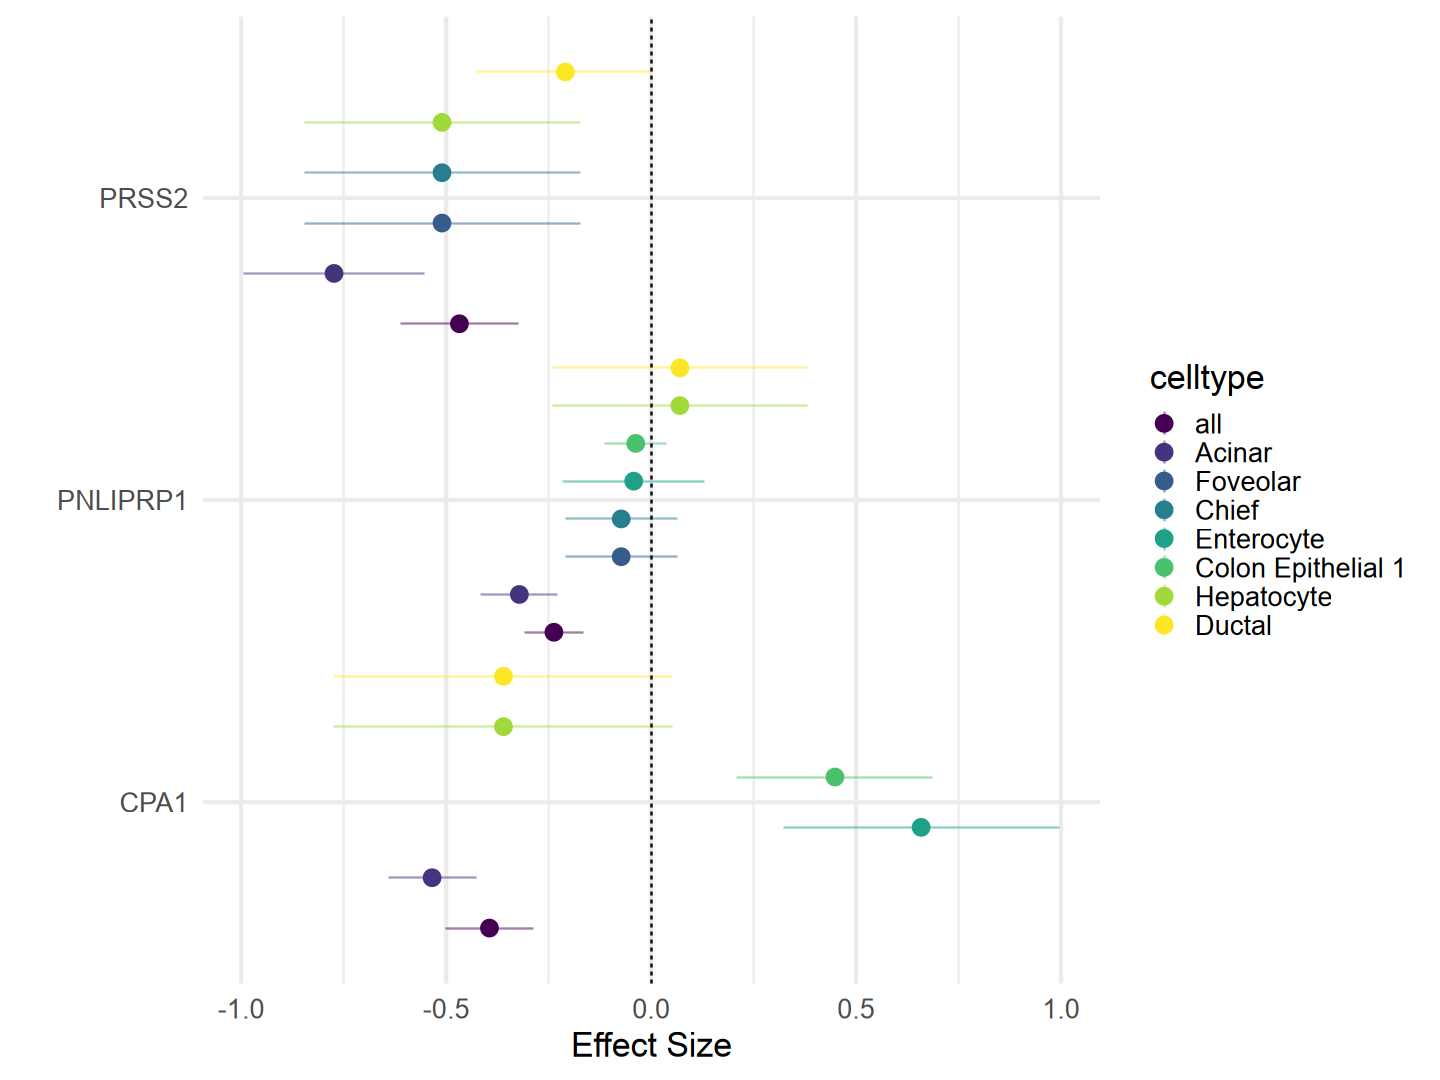

In [16]:
options(repr.plot.width=12, repr.plot.height=9)
ggplot(plot_all2, aes(x=exposure, y=b, ymin=b-se, ymax=b+se, fill=celltype, col=celltype)) + 
  geom_linerange(size=0.5,position=position_dodge(width = 1), alpha=0.5) +
  geom_hline(yintercept=0, lty=2) +
  geom_point(size=5, shape=16, stroke = NA,position=position_dodge(width = 1)) +
  ylab('Effect Size') +
  xlab('')+
  coord_flip() +
  theme_minimal(base_size=20)

In [2]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/relgamal/miniconda3/envs/R-notebooks/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Los_Angeles
tzcode source: system (glibc)

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] lubridate_1.9.3    forcats_1.0.0      purrr_1.0.2        readr_2.1.5       
 [5] tidyr_1.3.1        tibble_3.2.1       tidyverse_2.0.0    stringr_1.5.1     
 [9] ggrepel_0.9.5      lattice_